# Title HERE
---
* TEMP
* TEMP

# Notebook Setup
  * Import modules
  * Import data
  * Proprocessing

## Script Inputs

In [1]:
verbose = True

pH = 0

bias_range = [-3, 3]

## Import Modules

In [2]:
%%capture
# TEMP
import os
import sys

# # #############################################################################
# sys.path.insert(0,
#     os.path.join(
#         os.environ["PROJ_irox"],
#         "data"))
# from proj_data_irox import irox_bulk_color_map

# #############################################################################
sys.path.insert(0,
    os.path.join(
        os.environ["PROJ_irox"],
        "workflow"))
from an_data_processing import load_df
from an_data_processing import oxy_ref, hyd_ref

# # #############################################################################
import pickle
import pandas as pd
# import numpy as np
# import plotly.graph_objs as go
# import plotly.express as px

# # #############################################################################
from misc_modules.pandas_methods import drop_columns
from surface_energy.surface_energy import SurfaceEnergy

# from plotting.my_plotly import my_plotly_plot
# from surface_energy.surface_energy import SurfaceEnergyConvergence as SE_Conv

# # #############################################################################
# pd.set_option("display.max_columns", None)

# # #############################################################################
# from IPython.display import display

In [3]:
from proj_data_irox import irox_surface_e_color_map

import plotly.graph_objects as go

from plotting.my_plotly import my_plotly_plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from layout__v0 import layout

In [4]:
from proj_data_irox import bulk_e_per_atom_dict

## Read data

In [5]:
dataframe_dir = os.path.join(
    os.environ["PROJ_DATA"],
    "04_IrOx_surfaces_OER/190321_new_job_df")

df_pourbaix, df_ads, df_surf = load_df(
    from_file=True,
    root_dir=dataframe_dir,
    data_dir=dataframe_dir,
    file_name="df_master.pickle",
    process_df=True)
df_m = df_surf


# Filter the jobs that were unsuccessful
df_m = df_m[[not i for i in pd.isna(df_m["elec_energy"].tolist())]]
df_m = df_m[df_m["job_type"] == "surface_coverage_energy"]


cols_to_keep = [
    'facet',
    'job_type',
    'layers',
    'surface_type',
    'elec_energy',
    'atoms_object',
    'bulk_system',
    'coverage_type',
    ]

df_m = drop_columns(df=df_m, columns=cols_to_keep, keep_or_drop="keep")

Attempting to load df from pickle


## Read bulk data

In [6]:
bulk_data_path = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/an_bulk_systems",
    "bulk_systems.pickle")
with open(bulk_data_path, "rb") as fle:
    bulk_data = pickle.load(fle)

## Instantiate SurfaceEnergy objects

In [7]:
%%capture

def method(row_i):
    """
    """
    bulk_e_per_atom = bulk_e_per_atom_dict[row_i["bulk_system"]]

    SE = SurfaceEnergy(
        atoms=row_i["atoms_object"][-1],
        bulk_atoms=bulk_data[row_i["bulk_system"]],
        bulk_electronic_energy_per_atom=bulk_e_per_atom,
        H_ref_electronic_energy=hyd_ref,
        O_ref_electronic_energy=oxy_ref,
        verbose=verbose,
        )

    return(SE)

df_m["SurfaceEnergy"] = df_m.apply(
    method,
    axis=1,
    )

In [8]:
def method(row_i):
    """
    """
    SE_i = row_i["SurfaceEnergy"]

    norm_type = "area"  # 'area', 'surface_atom'
    # #############################################################################

    surf_e_left = SE_i.calc_surface_energy(bias_range[0], pH, norm_type="area")
    surf_e_right = SE_i.calc_surface_energy(bias_range[1], pH, norm_type="area")

    
    color_i = irox_surface_e_color_map.get(
        row_i["bulk_system"] + "_" + row_i["coverage_type"]
        )
    name_i = row_i["coverage_type"] + " " + row_i["facet"] 

    trace_i = go.Scatter(
        x=bias_range,
        y=[surf_e_left, surf_e_right],

        mode='markers+lines',
        name=name_i,
        marker=dict(
            symbol="square",
            size=10,
            color=color_i,
            line=dict(
                width=1,
                color='rgb(0, 0, 0)',
                ),
            ),
        )
    return(trace_i)


df_m["plotly_trace"] = df_m.apply(
    method,
    axis=1,
    )

In [9]:

# layout

In [10]:
data = df_m["plotly_trace"].tolist()


num_plots = len(df_m["bulk_system"].unique())

fig = make_subplots(
    rows=num_plots,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    )

In [11]:
%%capture
grouped = df_m.groupby(["bulk_system"])
for i_cnt, (name, group) in enumerate(grouped):

    trace_1_23 = go.Scatter(
        x= 2 * [1.23],
        y=[-5, 5],
        mode='lines',
        name="1.23",
        line = dict(
            color="black",
            width=1,
            dash="dot",
            ))
    fig.add_trace(trace_1_23, row=i_cnt + 1, col=1)

    for j_cnt, row_j in group.iterrows():
        fig.add_trace(
            row_j["plotly_trace"],
            row=i_cnt + 1,
            col=1,
            )    

fig.update_layout(layout)

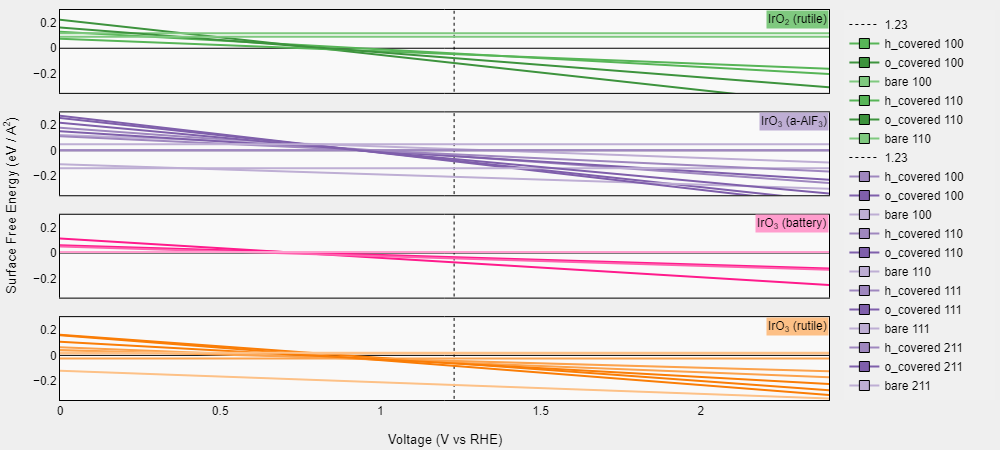

In [12]:
fig = my_plotly_plot(
    figure=fig,
    layout=None,
    layout_override=None,
    plot_name="TEMP",
    save_dir=None,
    data=None,
    upload_plot=False,
    )

fig.show()

In [13]:
%%capture

fig.layout.update(dict(
    showlegend=False,
    width=8.0 * 37.795275591,
    height=15.0 * 37.795275591,
    ))

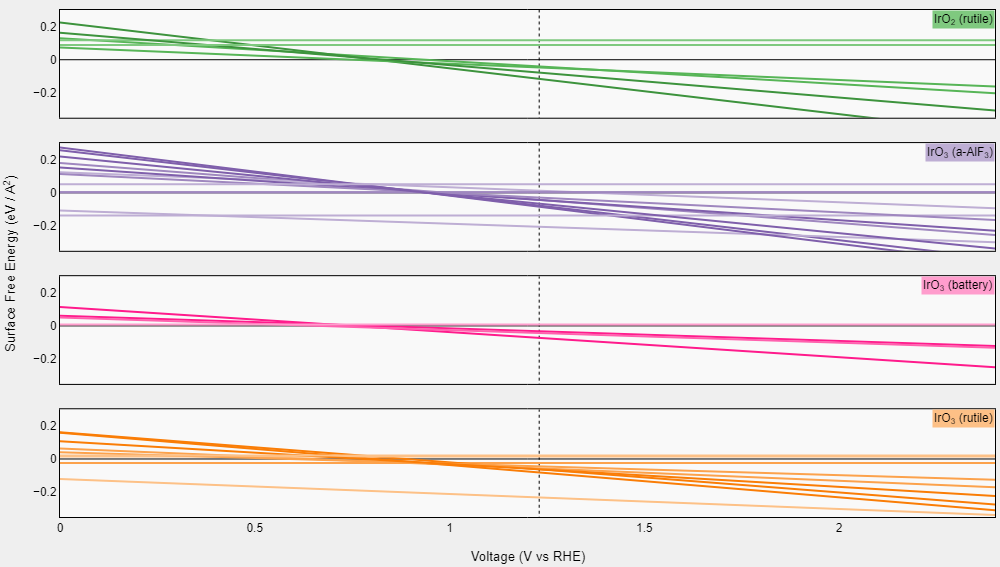

In [14]:
fig = my_plotly_plot(
    figure=fig,
    layout=None,
    layout_override=None,
    plot_name="TEMP",
    save_dir=None,
    data=None,
    upload_plot=False,
    )

fig.show()

In [15]:
# layout = go.Layout(
#     height=600,
#     width=800,
#     title_text="TEMP",
#     )

# # from proj_data_irox import irox_surface_e_color_map

# # irox_surface_e_color_map

# df_m
# row_i = df_m.iloc[0]

# name_i = row_i["coverage_type"] + row_i["facet"]

# # # row_i["bulk_system"] + "_" + row_i["coverage_type"]
# # irox_surface_e_color_map.get(row_i["bulk_system"] + "_" + row_i["coverage_type"])

# # fig.layout

# # font=dict(family='Courier New, monospace', size=18, color='#7f7f7f')

# go.Layout.font?

# go.layout.Font(
#     color="black",
# #     family,
# #     size,
#     )

In [16]:
# layout.shapes

# go.layout.Annotation?

In [17]:
# from proj_data_irox import irox_bulk_color_map

# irox_bulk_color_map

# subplot_label_rect_dict = dict(
#     type="rect",
#     # x0=1.5,
#     # y0=0.2,
#     x0=2,
#     y0=0.2,
#     # x1=2,
#     # y1=0.1,
#     x1=layout.xaxis.range[1],
#     y1=layout.yaxis.range[1],
#     xref="x2",
#     yref="y2",
#     line=dict(
#         color="black",
#         width=1,
#         ),
#     fillcolor="pink",
#     )

# shapes=[

#     go.layout.Shape(
#         **subplot_label_rect_dict,
#         ).update(
#             xref="x2",
#             yref="y2",
#             fillcolor=irox_bulk_color_map["IrO3"],
#             ),

#     go.layout.Shape(
#         **subplot_label_rect_dict,
#         ).update(
#             xref="x3",
#             yref="y3",
#             fillcolor=irox_bulk_color_map["IrO3_battery"],
#             ),
#     ]

In [18]:
from proj_data_irox import irox_bulk_color_map


irox_bulk_color_map

{'Ir': '#6799A3',
 'IrO2': '#7FC97F',
 'IrO3': '#BEAED4',
 'IrO3_a-AlF3': '#BEAED4',
 'IrO3_rutile-like': '#FDC086',
 'IrO3_battery': '#ff9dcd',
 'IrO4-': '#7c7c7c'}